In [1]:
datos=spark.read.text("../Ejemplos python/access_log")

In [2]:
datos.count(),datos.printSchema()

root
 |-- value: string (nullable = true)



(1546, None)

In [3]:
datos.show(3,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|64.242.88.10 - - [07/Mar/2004:16:05:49 -0800] "GET /twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables HTTP/1.1" 401 12846|
|64.242.88.10 - - [07/Mar/2004:16:06:51 -0800] "GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev1=1.3&rev2=1.2 HTTP/1.1" 200 4523                          |
|64.242.88.10 - - [07/Mar/2004:16:10:02 -0800] "GET /mailman/listinfo/hsdivision HTTP/1.1" 200 6291                                                      |
+---------------------------------------------------------------------

In [4]:
from pyspark.sql.functions import (regexp_extract,
                                   to_timestamp)

tabla=datos.select(\
 regexp_extract("value","(.+) - - ",1).alias("ip"),
 to_timestamp(regexp_extract("value","(.+) - - \[(.+)\]",2),
             "dd/MMM/yyyy:HH:mm:ss z").alias("fecha"),
 regexp_extract("value",'"(.+)"',1).alias("url"),
 regexp_extract("value",'" (\d{3}) ',1).alias("estado"),
 regexp_extract("value",'" \d{3} (.+)',1).cast("integer").alias("bytes")
)

tabla.show(2,vertical=True,truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------
 ip     | 64.242.88.10                                                                                   
 fecha  | 2004-03-08 01:05:49                                                                            
 url    | GET /twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables HTTP/1.1 
 estado | 401                                                                                            
 bytes  | 12846                                                                                          
-RECORD 1------------------------------------------------------------------------------------------------
 ip     | 64.242.88.10                                                                                   
 fecha  | 2004-03-08 01:06:51                                                                            
 url    | GET /twiki/bin/rdiff/TWiki/NewUserTe

In [5]:
tabla.groupBy("ip").sum("bytes")\
    .orderBy("sum(bytes)",ascending=False).show()

+--------------------+----------+
|                  ip|sum(bytes)|
+--------------------+----------+
|        64.242.88.10|   5745035|
|          10.0.0.153|   1200145|
|cr020r01-3.sac.ov...|    627328|
|h24-71-236-129.ca...|    250905|
|h24-70-69-74.ca.s...|    150461|
|mail.geovariances.fr|    138281|
| prxint-sxb3.e-i.net|    129557|
|ts05-ip44.hevanet...|    125673|
|ts04-ip92.hevanet...|    124082|
|pc3-registry-stoc...|    122885|
|market-mail.pandu...|     99393|
|     2-110.cnc.bc.ca|     87036|
|       128.227.88.79|     81785|
|      207.195.59.160|     81061|
|calcite.rhyolite.com|     75383|
|        212.92.37.62|     72981|
|p213.54.168.132.t...|     69429|
|ip68-228-43-49.tc...|     68712|
|crawl24-public.al...|     64972|
|    3_343_lt_someone|     62772|
+--------------------+----------+
only showing top 20 rows



In [6]:
dfUna=tabla.where(tabla.fecha.between("2004-03-08 01:00:00",
                                "2004-03-08 02:00:00"))

In [14]:
tabla.where(tabla.fecha.contains("2004-03-08 01")).count()

27

In [22]:

dfUna.count()

27

In [23]:
from pyspark.sql.functions import sum
dfUna.select(sum("bytes")).show()

+----------+
|sum(bytes)|
+----------+
|    352771|
+----------+



In [69]:
from pyspark.sql.functions import split
tabla2=tabla.withColumn("enlace",
    split(tabla.url,"[ \?]")[1]
    ).na.drop(subset="enlace")

tabla2.where(tabla2.enlace.isNull()).show(1,vertical=True,truncate=False)
tabla2.count()

(0 rows)



1545

In [70]:
tabla3=tabla.withColumn("enlace",
    regexp_extract(tabla.url,".* (.*)\?.*? .*$",1)
    )
tabla3.show(1,vertical=True,truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------
 ip     | 64.242.88.10                                                                                   
 fecha  | 2004-03-08 01:05:49                                                                            
 url    | GET /twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables HTTP/1.1 
 estado | 401                                                                                            
 bytes  | 12846                                                                                          
 enlace | /twiki/bin/edit/Main/Double_bounce_sender                                                      
only showing top 1 row



In [110]:
tabla3=tabla2.where(~tabla2.enlace.like("%.___"))\
    .groupBy("enlace").count()\
    .orderBy("count",ascending=False)

tabla3.show(truncate=False)

+--------------------------------------------+-----+
|enlace                                      |count|
+--------------------------------------------+-----+
|/twiki/bin/view/Main/WebHome                |49   |
|/                                           |47   |
|/razor.html                                 |26   |
|/twiki/bin/view/Main/SpamAssassinTaggingOnly|18   |
|/twiki/bin/view/Main/SpamAssassinAndPostFix |17   |
|/twiki/bin/view/Main/SpamAssassinDeleting   |15   |
|/dccstats/index.html                        |14   |
|/mailman/listinfo/ppwc                      |13   |
|/twiki/bin/search/TWiki/SearchResult        |13   |
|/twiki/bin/view/Main/DCCAndPostFix          |12   |
|/twiki/bin/view/TWiki/TextFormattingRules   |12   |
|/SpamAssassin.html                          |12   |
|/mailman/admin/ppwc                         |12   |
|/twiki/bin/view/Main/PostfixCommands        |11   |
|/AmavisNew.html                             |11   |
|/mailman/listinfo                           |

In [114]:
tablaP=tabla3.limit(5).toPandas()


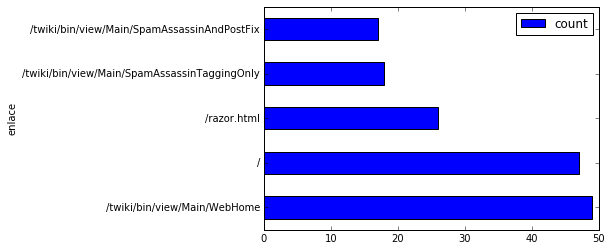

In [116]:
tablaP.plot.barh(x="enlace")

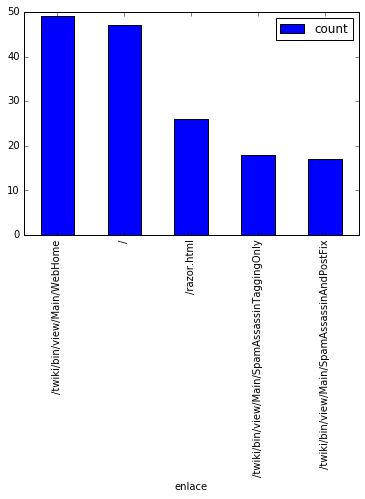

In [117]:
tablaP.plot.bar(x="enlace")

In [68]:
tabla.count(),tabla.na.drop().count()

(1546, 1407)

In [70]:
tabla.where(tabla.bytes.isNull()).show(vertical=True)

-RECORD 0----------------------
 ip     | 80-219-148-207.dc... 
 fecha  | 2004-03-08 04:47:36  
 url    | OPTIONS * HTTP/1.0   
 estado | 200                  
 bytes  | null                 
-RECORD 1----------------------
 ip     | 68-174-110-154.ny... 
 fecha  | 2004-03-08 14:38:57  
 url    | GET /razor.html H... 
 estado | 304                  
 bytes  | null                 
-RECORD 2----------------------
 ip     | 128.227.88.79        
 fecha  | 2004-03-08 15:57:46  
 url    | GET /twiki/pub/TW... 
 estado | 304                  
 bytes  | null                 
-RECORD 3----------------------
 ip     | 10.0.0.153           
 fecha  | 2004-03-08 17:32:24  
 url    | GET / HTTP/1.1       
 estado | 304                  
 bytes  | null                 
-RECORD 4----------------------
 ip     | 10.0.0.153           
 fecha  | 2004-03-08 17:32:27  
 url    | GET /twiki/pub/TW... 
 estado | 304                  
 bytes  | null                 
-RECORD 5----------------------
 ip     